In [101]:
# ===========================
# 📦 Import Libraries
# ===========================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb

import joblib

In [78]:
# ===========================
# 📥 Load Dataset
# ===========================

df = pd.read_csv("/kaggle/input/house-price-prediction-dataset/House Price Prediction Dataset.csv")

In [79]:
# ===========================
# 📊 Basic Data Exploration
# ===========================

print(df.head())
print(df.shape)
print(df.describe())
print(df.info())
print(df.isnull().sum())

   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   966         4          2       2       1902  Suburban       Fair   
4   5  4926         1          4       2       1975  Downtown       Fair   

  Garage   Price  
0     No  149919  
1     No  424998  
2     No  266746  
3    Yes  244020  
4    Yes  636056  
(2000, 10)
                Id         Area     Bedrooms   Bathrooms       Floors  \
count  2000.000000  2000.000000  2000.000000  2000.00000  2000.000000   
mean   1000.500000  2786.209500     3.003500     2.55250     1.993500   
std     577.494589  1295.146799     1.424606     1.10899     0.809188   
min       1.000000   501.000000     1.000000     1.00000     1.000000   
25%     500.750000  1653.000000     2.000000     2.00

In [80]:
# ===================================
# 🔍 Encode Categorical Features
# ===================================


categorical_cols = ['Location', 'Condition', 'Garage']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [81]:
# ===========================
# 🔗 Encode Categorical Features
# ===========================

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("\nData after encoding:\n", df.head())



Data after encoding:
    Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970         0          0   
1   2  4272         5          4       3       1958         0          0   
2   3  3592         2          2       3       1938         0          2   
3   4   966         4          2       2       1902         2          1   
4   5  4926         1          4       2       1975         0          1   

   Garage   Price  
0       0  149919  
1       0  424998  
2       0  266746  
3       1  244020  
4       1  636056  


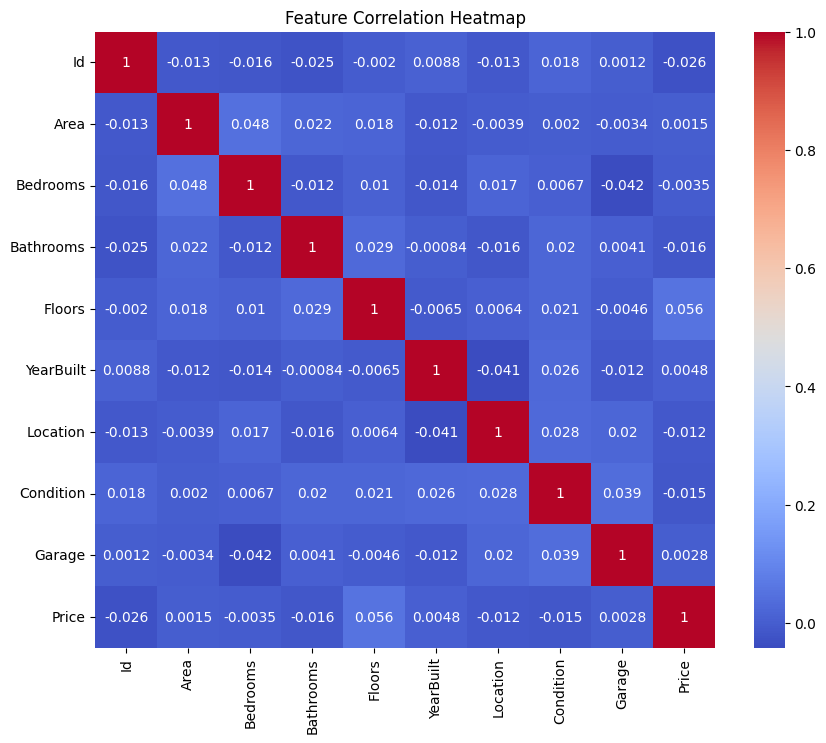

In [82]:
# ===========================
# 🔥 Correlation Heatmap
# ===========================


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [83]:
# ===========================
# ✂ Split Data
# ===========================


X = df.drop(['Id', 'Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [84]:
# ===========================
# Scale the numeric columns
# ===========================


numeric_cols = ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']

scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nSample scaled data:\n", X_train.head())


Sample scaled data:
          Area  Bedrooms  Bathrooms    Floors  YearBuilt  Location  Condition  \
968  1.314081  0.685758   1.316088  1.242260  -0.808673         3          0   
240 -1.315960 -0.014889   0.414272 -1.236064   0.221883         0          2   
819 -1.039194 -0.014889   1.316088 -1.236064   0.862499         3          2   
692 -0.088966 -0.715536   0.414272 -1.236064   0.277589         1          3   
420  0.393836 -0.715536   1.316088 -1.236064   0.528264         1          0   

     Garage  
968       0  
240       0  
819       1  
692       1  
420       1  


In [85]:
# ===========================
# 📊 Model Results Dictionary
# ===========================

results = {}


In [86]:
# ===========================
# 📈 Linear Regression
# ===========================
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

results['Linear Regression'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}


In [87]:
# ===========================
# 📈 Linear Regression (Log-Transformed)
# ===========================


y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


lr.fit(X_train, y_train_log)
y_pred_lr_log = lr.predict(X_test)
rmse_lr_log = np.sqrt(mean_squared_error(y_test_log, y_pred_lr_log))
r2_lr_log = r2_score(y_test_log, y_pred_lr_log)

results['Linear Regression (Log-Transformed)'] = {
    'RMSE' : (rmse_lr_log),
    'R2' : (r2_lr_log)
}

In [88]:
# ===========================
# 🌳 Random Forest
# ===========================
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}

In [95]:
# ===========================
# 🌳 Random Forest (Tuned)
# ===========================


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2_best_rf = r2_score(y_test, y_pred_best_rf)

results['Random Forest (Tuned)'] = {
    'RMSE' : (rmse_best_rf),
    'R2' : (r2_best_rf)
}



Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [90]:
# ===========================
# 🌲 Extra Trees Regressor
# ===========================
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)

results['Extra Trees'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_et)),
    'R2': r2_score(y_test, y_pred_et)
}

In [91]:
# ===========================
# 📈 Gradient Boosting Regressor
# ===========================
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

results['Gradient Boosting'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
    'R2': r2_score(y_test, y_pred_gbr)
}

In [92]:
# ===========================
# ⚡ XGBoost Regressor
# ===========================
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)

results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgbr)),
    'R2': r2_score(y_test, y_pred_xgbr)
}

In [93]:
# ===========================
# 💡 LightGBM Regressor
# ===========================
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

results['LightGBM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lgbm)),
    'R2': r2_score(y_test, y_pred_lgbm)
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] Start training from score 536183.700000


In [96]:
# ===========================
# 📊 Display Results
# ===========================
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print("\n🔍 Model Performance Comparison:\n")
print(results_df)


🔍 Model Performance Comparison:

                                              RMSE        R2
Linear Regression (Log-Transformed)       0.750402 -0.008569
Linear Regression                    280587.637402 -0.011962
Gradient Boosting                    283970.404482 -0.036509
Random Forest (Tuned)                286655.311308 -0.056202
Random Forest                        293800.026301 -0.109508
LightGBM                             298967.475010 -0.148880
Extra Trees                          315088.274908 -0.276120
XGBoost                              324733.457035 -0.355442


In [97]:
# ===========================
# Saving the Best Model
# ===========================

joblib.dump(lr, 'linear_regression_log_model.pkl')

print("✅ Model saved as 'linear_regression_log_model.pkl'")


✅ Model saved as 'linear_regression_log_model.pkl'


In [100]:
# ==========================================
# Predicting the price of an Example 
# ==========================================


# Load the saved model
model = joblib.load('linear_regression_log_model.pkl')

# Prepare input data as DataFrame
input_data = pd.DataFrame({
    'Area': [2500],
    'Bedrooms': [4],
    'Bathrooms': [3],
    'Floors': [2],
    'YearBuilt': [2010],
    'Location': [2],    # Make sure you encode like before
    'Condition': [3],   # e.g., 'Good'
    'Garage': [1]       # e.g., 'Yes'
})

# Predict log(price)
log_predicted_price = model.predict(input_data)

# Convert back from log scale
predicted_price = np.expm1(log_predicted_price)

print(f"Predicted House Price: ₹ {predicted_price[0]:,.2f}")


Predicted House Price: ₹ 12,448,523.26
